https://www.gurobi.com/academia/academic-program-and-licenses/

https://www.gurobi.com/jupyter_models/
https://www.gurobi.com/resources/math-programming-modeling-basics/

See https://support.gurobi.com/hc/en-us/articles/14799677517585 for Getting Started with Gurobi Optimizer

See https://support.gurobi.com/hc/en-us/articles/17278438215313 for Tutorial: Getting Started with the Gurobi Python API

## <font color=red>(Part A) Two basic problems from www.gurobi.com</font>
Study the two models below and the required steps to get to the solution: defining variables, objective & constaints; solve the model; and finally present the solution.

For the first model "LP1: A Very Basic LP-model" this should be self-explanatory. At the end, the feasible region is graphically represented. By changing the objective, the optimal solution might change and therefore red dot in the graph as well.

For the second model "LP2" you can recognize the same steps, but now the numerical solution is presented with all its attributes. These attributes are useful for Sensitivity Analysis (topic of later lectures) and are only available for continuous problems. Also code is added that is especially helpfull during the development of your model. Your first attempt might lead to an unbounded solution, or it might be an infeasible model.

In [ ]:
!pip install gurobipy

Product 1: 2.4
Product 2: 1.6


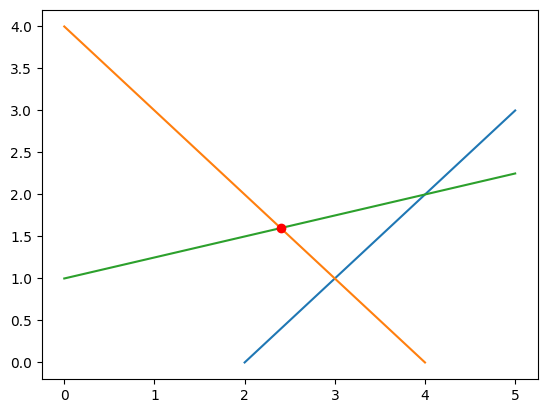

In [ ]:
from gurobipy import *

m  = Model("LP1: A Very Basic LP-model")
x1 = m.addVar(name = "Product 1")           # Define decision variables
x2 = m.addVar(name = "Product 2")

m.addConstr(      x1 - x2 <= 2)             # Define constraint 1
m.addConstr(      x1 + x2 <= 4)             # Define constraint 2
m.addConstr(-0.25*x1 + x2 <= 1)             # Define constraint 3

m.setObjective(  x2, GRB.MAXIMIZE)          # Specify objective function and direction (GRB.MINIMIZE for minimization, GRB.MAXIMIZE for maximization)
m.params.LogToConsole = 0                   # Avoid output from solver to screen
m.optimize()

for v in m.getVars():                       # Show the value of all variables in the optimal solution
    print('%s: %g' % (v.VarName, v.X))

import matplotlib.pyplot as pyplot          # Draw all borders of the feasible region:
pyplot.plot([2,5], [0,3])                   #     Constraint 1: line-segment from point (2, 0) to (5, 3)
pyplot.plot([4,0], [0,4])                   #     Constraint 2
pyplot.plot([0,5], [1,2.25])                #     Constraint 3
pyplot.plot([x1.x], [x2.x], 'ro')           # Draw optimal vertex
pyplot.show()                               # Feasible region: below the green and orange line & above the blue line

In [ ]:
from gurobipy import *

try:
    # Create a new model
    m = Model("LP2")
    m.Params.LogToConsole = 0

    # Create variables
    x = m.addVar(name = "X")
    y = m.addVar(name = "Y")
    z = m.addVar(name = "Z")

    # Set objective
    m.setObjective(x + y + 2 * z, GRB.MAXIMIZE)

    # Add constraint: x + 2 y + 3 z <= 4
    m.addConstr(x + 2*y + 3*z <= 4, "Constraint 0")

    # Add constraint: x + y >= 1
    m.addConstr(x + y >= 1, "Constraint 1")

    # Optimize model
    print(f'Model has {m.NumVars} variables, {m.NumConstrs} constraints and {m.NumNZs} nonzeros\n')
    m.optimize()
    print(f'Model has {m.NumVars} variables, {m.NumConstrs} constraints and {m.NumNZs} nonzeros\n')

    # Check outcome of the model
    status = m.Status
    if status == GRB.UNBOUNDED:
        print("The model cannot be solved because it is unbounded")
    elif status == GRB.OPTIMAL:
        print(f"The optimal objective is {m.ObjVal:6.2}")
    elif status != GRB.INF_OR_UNBD and status != GRB.INFEASIBLE:
        print(f"Optimization was stopped with status {status}")
    if status != GRB.OPTIMAL:
        print("Status code: ", status, "\nSee: https://www.gurobi.com/documentation/11.0/refman/optimization_status_codes.html#sec:StatusCodes")

    # Print for all variables the most relevant attributes
    print("\nVarName           |     x_j   low &  up   |     c_j  low & up       type")
    for v in m.getVars():
        print(f"{v.VarName:17} |{v.X:8.3f} {v.lb:6.2f} {v.ub:6.2f} |{v.obj:8.2f} {v.saobjlow:6.2f} {v.saobjup:6.2f}    {v.vtype:3} ")

    # Print for all constraints the most relevant attributes
    print("\nConstrName        |    RHS    low &  up   |   Slack     Pi   CBasis")
    for c in m.getConstrs():
        print(f"{c.ConstrName:17} |{c.rhs:8.2f} {c.SArhslow:6.2f} {c.SArhsup:6.2f} |{c.Slack:8.2f} {c.pi:6.2f} {c.cbasis:6}    {c.Sense}=")

except gp.GurobiError as e:
    print('Error code ' + str(e.errno) + ': ' + str(e))
except AttributeError:
    print('Encountered an attribute error')

Model has 0 variables, 0 constraints and 0 nonzeros

Model has 3 variables, 2 constraints and 5 nonzeros

The optimal objective is    4.0

VarName           |     x_j   low &  up   |     c_j  low & up       type
X                 |   4.000   0.00    inf |    1.00   0.67    inf    C   
Y                 |   0.000   0.00    inf |    1.00   -inf   2.00    C   
Z                 |   0.000   0.00    inf |    2.00   -inf   3.00    C   

ConstrName        |    RHS    low &  up   |   Slack     Pi   CBasis
Constraint 0      |    4.00   1.00    inf |    0.00   1.00     -1    <=
Constraint 1      |    1.00   -inf   4.00 |   -3.00   0.00      0    >=


## <font color=red>(Part B) Dovetail problem</font>
From <I>Linear and Integer Optimization</I>, Gerard Sierksma & Yori Zwols, 3$^{ed}$, CRC Press, 2015 (Chapter 1.1, page 2).
<OL>
    
###  Explicit formulation of the model
This is not the preferred way, as this approach produces (very) long formulations for model with more variables / constraints and does not emphisise the essence of the model very well.

In [ ]:
from gurobipy import *

m = Model("Dovetail 1")                        # All equations written out
m.Params.LogToConsole = 0

x1 = m.addVar(ub = 7, name = "Long matches ")     # NB. by default lb = 0, so when defining variables take care of part D and E
x2 = m.addVar(ub = 6, name = "Short matches")     # lb: lower bound, ub:upper bound

m.setObjective(3 * x1 + 2 * x2, GRB.MAXIMIZE)

m.addConstr(     x1 + x2 <=  9, 'max # of boxes')
m.addConstr( 3 * x1 + x2 <= 18, 'max avail wood')

print("\nFirst, we solve the DoveTail problem as formulated in the book")
print("-------" * 10)

m.optimize()

print(f'Model has {m.NumVars} variables, {m.NumConstrs} constraints and {m.NumNZs} nonzeros\n')
print(f"The optimal objective is {m.ObjVal:g}")
print("\nVarName           |     x_j   low &  up   |     c_j  low & up")
for v in m.getVars():
    print(f"{v.VarName:17} |{v.X:8.2f} {v.lb:6.2f} {v.ub:6.2f} |{v.obj:8.2f} {v.saobjlow:6.2f} {v.saobjup:6.2f}")
print("\nConstrName        |    RHS    low &  up   |   Slack     Pi ")
for c in m.getConstrs():
    print(f"{c.ConstrName:17} |{c.rhs:8.2f} {c.SArhslow:6.2f} {c.SArhsup:6.2f} |{c.Slack:8.2f} {c.pi:6.2f}")


First, we solve the DoveTail problem as formulated in the book
----------------------------------------------------------------------
Model has 2 variables, 2 constraints and 4 nonzeros

The optimal objective is 22.5

VarName           |     x_j   low &  up   |     c_j  low & up
Long matches      |    4.50   0.00   7.00 |    3.00   2.00   6.00
Short matches     |    4.50   0.00   6.00 |    2.00   1.00   3.00

ConstrName        |    RHS    low &  up   |   Slack     Pi 
max # of boxes    |    9.00   6.00  10.00 |    0.00   1.50
max avail wood    |   18.00  15.00  23.00 |    0.00   0.50


In [ ]:
#  Make sure that the previous cell has just been executed.

print("\nNext, we add an additional constraint")
print("-------" * 10)
m.addConstr(2*x1 + x2 <= 12, 'resource3') # give a name 'resource3' to this constraint
m.optimize()

print(f'New model has {m.NumVars} variables, {m.NumConstrs} constraints and {m.NumNZs} nonzeros\n')
print(f'New optimal solution with z = {m.ObjVal:g} found')
print('\nNew solution:')
for v in m.getVars():
    print(f"{v.VarName:17} |{v.X:8.2f} {v.lb:6.2f} {v.ub:6.2f} |{v.obj:8.2f} {v.saobjlow:6.2f} {v.saobjup:6.2f}")


Next, we add an additional constraint
----------------------------------------------------------------------
New model has 2 variables, 5 constraints and 10 nonzeros

New optimal solution with z = 1.6 found

New solution:
Product 1         |    2.40   0.00    inf |    0.00  -0.25   1.00
Product 2         |    1.60   0.00    inf |    1.00  -0.00    inf


## <font color=red>(Part B) Dovetail problem</font>
From <I>Linear and Integer Optimization</I>, Gerard Sierksma & Yori Zwols, 3$^{ed}$, CRC Press, 2015 (Chapter 1.1, page 2).
<OL>
    
###  More general way of formulating the model
This is the preferred way, as the model is separated from the data and the utilization of the model is not just limited to solving one specific problem instance. The model in the cell still has two constraints, but can now be used with different numbers of products. It also demonstrates the often used Gurobi functions <code>x.sum</code> and <code>quicksum</code>. These type of models are referred to as symbolic-indexed, or parametrized-indexed models.

Furthermore, the specification of the model is implemented as a function. In practice, a model is often used for solving  several problem instances, or with slightly adjusted values of the parameters (Sensitivity Analysis). In the next cells four examples of using the DoveTailProblem are given:

- two problem instances of the Dovetail proble are solved
- a manual Sensitivity Analysis of one of the RHS coefficients of the model.
- a Full Parametric Sensitivity Analysis of one of the RHS coefficients of the model, i.e. the perturbation function  $𝑧^∗(𝑏_1
 )$ is determined. See e.g. Figure 5.6 from the book.
- a Full Parametric Sensitivity Analysis of one of the coefficients of the objective of the model, i.e. the perturbation function  $𝑧^∗(𝑐_1)$ is determined. See e.g. Figure 5.4 from the book.

In [ ]:
from gurobipy import *

def DoveTailProblem():

    n = len(Bounds)
    m = Model("Dovetail2")                             # Same model, different Python formulation
    m.Params.LogToConsole = 0

    # Section with model specification (separated from the data)
    x = m.addVars(n, name="Matches", ub=Bounds)
    m.setObjective(quicksum(Profit[i] * x[i] for i in range(n)), GRB.MAXIMIZE)

    m.addConstr( x.sum() <=  MaxRHS[0], 'max # of boxes')
    m.addConstr( quicksum(Coeffs[i] * x[i] for i in range(n)) <= MaxRHS[1], 'max avail resource')
    return m

In [ ]:
# Section with parameters (the required data for your model)
Bounds = [7, 6]
Profit = [3, 2]
Coeffs = [3, 1]
MaxRHS = [9, 18]

# Combine the data with your model to solve this specific problem instance
dt = DoveTailProblem()
dt.optimize()

print(f'Problem instances 1: Model has {dt.NumVars} variables, {dt.NumConstrs} constraints and {dt.NumNZs} nonzeros')
print(f"The optimal objective is {dt.ObjVal:g}")
print("VarName           |     x_j")
for v in dt.getVars():
    print(f"{v.VarName:17} |{v.X:8.2f} ")

# Section with parameters for a second problem instance
Bounds = [7, 6, 5]
Profit = [3, 2, 4]
Coeffs = [3, 1, 2]
MaxRHS = [9, 18, 15]

dt = DoveTailProblem()
dt.optimize()
print(f'\n\nProblem instances 2: Model has {dt.NumVars} variables, {dt.NumConstrs} constraints and {dt.NumNZs} nonzeros')
print(f"The optimal objective is {dt.ObjVal:g}")
print("VarName           |     x_j")
for v in dt.getVars():
    print(f"{v.VarName:17} |{v.X:8.2f} ")

Problem instances 1: Model has 2 variables, 2 constraints and 4 nonzeros
The optimal objective is 22.5
VarName           |     x_j
Matches[0]        |    4.50 
Matches[1]        |    4.50 


Problem instances 2: Model has 3 variables, 2 constraints and 6 nonzeros
The optimal objective is 30
VarName           |     x_j
Matches[0]        |    2.00 
Matches[1]        |    2.00 
Matches[2]        |    5.00 


In [ ]:
# Back to the original problem
Bounds = [7, 6]
Profit = [3, 2]
Coeffs = [3, 1]
MaxRHS = [9, 18]

dt = DoveTailProblem()
dt.optimize()
z1 = dt.ObjVal
print(f'First optimal solution with z = {z1:6.2f}')

dt.getConstrs()[1].rhs = 19                    # Changing the RHS of the second (!) constraint
dt.optimize()
z2 = dt.ObjVal

print(f'New   optimal solution with z = {z2:6.2f}')
print(f'Shadow price for  resource 2  = {z2-z1:6.2f}')

First optimal solution with z =  22.50
New   optimal solution with z =  23.00
Shadow price for  resource 2  =   0.50


<ipython-input-14-ec5980d2b61c>:14: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


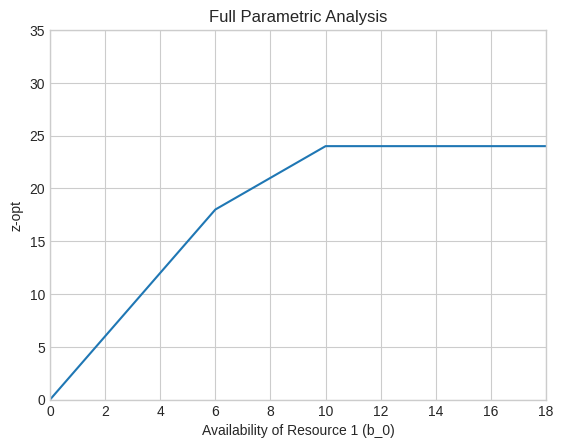

In [ ]:
# Back to the original problem
dt = DoveTailProblem()
dt.update()

# Specify a range of values for your parameter of interest, here b_0 (the RHS of the first constraint)
bees  = range(19)
z_all = []                                      # Keeping track of all optimal values
for b0 in bees:
    dt.getConstrs()[0].rhs = b0                 # Simular as above; here with a series of values
    dt.optimize()
    z_all.append(dt.ObjVal)

import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
ax = plt.axes()
ax.plot(bees, z_all)
ax.set(xlim=(0, 18), ylim=(0, 35), title="Full Parametric Analysis", xlabel="Availability of Resource 1 (b_0)", ylabel="z-opt");

<ipython-input-15-2efa6f06b8be>:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


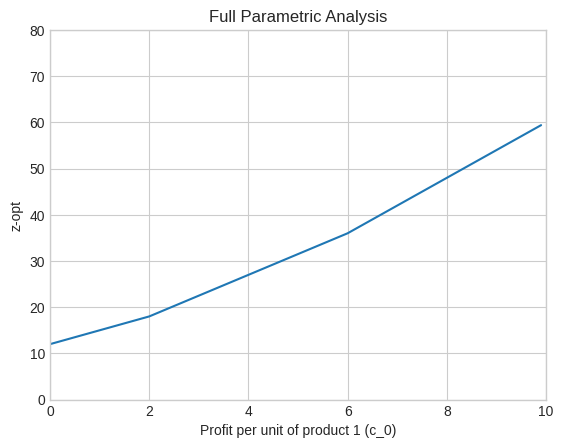

In [ ]:
import numpy as np

# Back to the original problem
dt = DoveTailProblem()
dt.update()

# Specify a range of values for your parameter of interest, here c_0 (the coefficient of the first variable)
cees  = np.arange(0, 10, 0.1)
z_all = []                                               # Keeping track of all optimal values for i in x:
for c0 in cees:
    dt.getVars()[0].obj = c0                             # Changing the python variable Profit[0] will have no effect
    dt.optimize()
    z_all.append(dt.ObjVal)

plt.style.use('seaborn-whitegrid')
ax = plt.axes()
ax.plot(cees, z_all)
ax.set(xlim=(0, 10), ylim=(0, 80), title="Full Parametric Analysis", xlabel="Profit per unit of product 1 (c_0)", ylabel="z-opt");

## <font color=red>(Part C) Add your own models</font>

### Now, solve 2 of the 5 models for problem W1.0 ... W1.4


# Assignment 1
#### **Author**: *Anton Pham* 13179543, *Bowen Ma* 12960780, *Weichen Fang* 13218115
 Question W1.0 and W1.2 are the designated questions based on our student numbers

# W1.0 - Model Formulation  
### $\mathrm{I.}$ Decision Variables
We assign numerical values (1, 2, 3, 4) to different materials of backpacks, representing Canvas, Plastic, Nylon, and Leather, respectively.We define,  
$x_i:=$ number of backpack $i$ produced by the end of the following week, $i \in \{1, 2, 3, 4\}$.  
### $\mathrm{II.}$ Objective Function
\begin{aligned}
&\max\quad 35.5x_1+39.5x_2+42.5x_3+69.5x_4-(2.25\cdot4.5x_1+2.4\cdot4.25x_2+2.1\cdot7.65x_3+2.6\cdot9.45x_4)-(1.5\cdot7(x_1+x_2)+1.7\cdot8x_3+1.9\cdot9x_4)\\
⟹\\
&\max\quad 14.875x_1+18.8x_2+12.835x_3+27.83x_4\end{aligned}
### $\mathrm{III.}$  Constraints
\begin{align}
\begin{cases}
15\leq x_1,x_2,x_3,x_4\leq40\\
1.5(x_1+x_2)\leq90\\1.7x_3\leq42.5\\
1.9x_4\leq80\\
2.25x_1\leq200\\
2.4x_2\leq350\\
2.1x_3\leq700\\
2.6x_4\leq550
\end{cases},
⟹
\begin{cases}
x_1\leq40\\-x_1\leq-15\\
x_2\leq40\\-x_2\leq-15\\
x_3\leq25\\-x_3\leq-15\\
x_4\leq40\\-x_4\leq-15\\
x_1+x_2\leq60
\end{cases}
\end{align}
### $\mathrm{IV.}$ Matrix form
\begin{align}
\max\quad \bigg\{\begin{bmatrix}14.875\\18.8\\12.835\\27.93\end{bmatrix}^T\begin{bmatrix}x_1\\x_2\\x_3\\x_4\end{bmatrix}\bigg|\begin{bmatrix}1&0&0&0\\-1&0&0&0\\0&1&0&0\\0&-1&0&0\\0&0&1&0\\0&0&-1&0\\0&0&0&1\\0&0&0&-1\\1&1&0&0\end{bmatrix}\begin{bmatrix}x_1\\x_2\\x_3\\x_4\end{bmatrix}\leq\begin{bmatrix}40\\-15\\40\\-15\\40\\-15\\40\\-15\\60\end{bmatrix}\bigg\}
\end{align}

In [ ]:
# Code for solving W1.0
from gurobipy import *

def BackpackProblem():
    n = 4
    m = Model("BackpackProblem")
    m.Params.LogToConsole = 0
    backpacks=['Canvas', 'Plastic','Nylon', 'Leather']
    # Section with model specification (separated from the data)
    x = m.addVars(n, name=backpacks, ub=UpperBounds, lb=LowerBounds)

    m.setObjective(quicksum(Profit[i] * x[i] for i in range(n)), GRB.MAXIMIZE)

    # Add constraints here if needed
    m.addConstr(x[0]+x[1] <= 60, 'time constraint for worker')

    m.optimize()

    print(f'Model has {m.NumVars} variables, {m.NumConstrs} constraints and {m.NumNZs} nonzeros\n')
    print(f"The optimal objective is {m.ObjVal:g}")
    print("\nVarName           |     x_j   low &  up   |     c_j  low & up")
    for v in m.getVars():
        print(f"{v.VarName:17} |{v.X:8.2f} {v.lb:6.2f} {v.ub:6.2f} |{v.obj:8.2f} {v.saobjlow:6.2f} {v.saobjup:6.2f}")
    print("\nConstrName        |    RHS    low &  up   |   Slack     Pi ")
    for c in m.getConstrs():
        print(f"{c.ConstrName:17} |{c.rhs:8.2f} {c.SArhslow:6.2f} {c.SArhsup:6.2f} |{c.Slack:8.2f} {c.pi:6.2f}")
    profit_optimized = dict((v.varName, v.x) for v in m.getVars())
    print(profit_optimized)

    return m

# Data definition
n = 4
Profit = [14.875, 18.8, 12.835, 27.83]
UpperBounds = [40, 40, 25, 40]
LowerBonds = [15, 15, 15, 15]

# Call the function
model = BackpackProblem()

Restricted license - for non-production use only - expires 2025-11-24
Model has 4 variables, 1 constraints and 2 nonzeros

The optimal objective is 2483.57

VarName           |     x_j   low &  up   |     c_j  low & up
Canvas            |   20.00  15.00  40.00 |   14.88  -0.00  18.80
Plastic           |   40.00  15.00  40.00 |   18.80  14.88    inf
Nylon             |   25.00  15.00  25.00 |   12.84  -0.00    inf
Leather           |   40.00  15.00  40.00 |   27.83  -0.00    inf

ConstrName        |    RHS    low &  up   |   Slack     Pi 
time constraint for worker |   60.00  55.00  80.00 |    0.00  14.88
{'Canvas': 20.0, 'Plastic': 40.0, 'Nylon': 25.0, 'Leather': 40.0}


### $\mathrm{V.}$  Conclusion
To optimize profits, the manufacturer should consider producing a specific quantity of each bag type: 20 canvas bags, 40 plastic bags, 25 nylon bags, and 40 leather bags. The maximum achievable profit from this production mix is $2,483.57.

# W1.1 - Model Formulation

### $\mathrm{I.}$ Decision Variables
We assign numerical values (1, 2, 3, 4, 5, 6) to different ingredient, representing beef, pork, corn, lamb, rice, chicken, respectively. We define,  
$x_i:=$pound of $i$ needed to produce per pound puppy food, $i \in \{1, 2, 3, 4, 5, 6\}$.  

### $\mathrm{II.}$ Objective Function
\begin{aligned}
&\min\quad 0.52x_1 + 0.49x_2 + 0.20x_3 + 0.40x_4 + 0.17x_5 + 0.39x_6\\
\end{aligned}

### $\mathrm{III.}$  Constraints
\begin{aligned}
\begin{cases}
-0.169x_1 - 0.12x_2 - 0.085x_3 - 0.154x_4 - 0.085x_5 - 0.18x_6 \leq -0.16\\
-0.26x_1 - 0.041x_2 - 0.038x_3 - 0.063x_4 - 0.038x_5 - 0.179x_6 \leq -0.13\\
0.29x_1 + 0.083x_2 + -0.027x_3 + 0.024x_4 + 0.027x_5 + 0.288 \leq 0.15 \\
x_1 +x_2+x_3+x_4+x_5+x_6 = 1\\
x_1, x_2,x_3,x_4,x_5,x_6 \geq 0\\
\end{cases}
\end{aligned}

### $\mathrm{IV.}$ Matrix form
\begin{align}
\min\quad \bigg\{\begin{bmatrix}0.52\\0.49\\0.20\\0.40\\0.17\\0.39\end{bmatrix}^T\begin{bmatrix}x_1\\x_2\\x_3\\x_4\\x_5\\x_6\end{bmatrix}\bigg|\begin{bmatrix}-0.169 & -0.12 & -0.085 & -0.154 & -0.085 &- 0.18\\ -0.26 & -0.041 & -0.038 & -0.063 & -0.038 & -0.179\\ 0.29 & 0.083 & 0.027 & 0.024 & 0.027 & 0.288 \end{bmatrix}\begin{bmatrix}x_1\\x_2\\x_3\\x_4\\x_5\\x_6\end{bmatrix}\leq\begin{bmatrix}-0.16\\-0.13\\0.15\end{bmatrix},\begin{bmatrix}x_1\\x_2\\x_3\\x_4\\x_5\\x_6\end{bmatrix}\geq0, \begin{bmatrix}
1 & 1 & 1 & 1 & 1 & 1
\end{bmatrix}
\begin{bmatrix}
x_1 \\
x_2 \\
x_3 \\
x_4 \\
x_5 \\
x_6
\end{bmatrix} = 1\bigg\}
\end{align}


# W1.2 - Model Formulation  
### $\mathrm{I.}$ Decision Variables
We assign numerical values (1, 2) to the amount of Pork and Beef used, beside the 25% of 2-ounce all-meat hot dog, and (3, 4) representing Chicken and Turkey, respectively. We define,  
$x_i:=$ the amount of the ingredient $i$ needed to produce 2-ounce all-meat hot dog, $i\in \{3, 4\}$\
$x_i:=$ the extra amount of the ingredient $i$ needed to produce 2-ounce all meat hot dog, $i\in\{1,2\}$\
$x_i$ in unit of pound


\begin{array}{|l|l|l|l|l|}
\hline
\text{Meat} & \text{Cost(\$)/pound} & \text{Calories/pound} & \text{Fat/(gr/lb.)} & \text{Cholesterol/(gr/lb.)} \\
\hline
\text{Beef} & 0.76 & 640 & 32.5 & 210 \\
\text{Pork} & 0.82 & 1055 & 54 & 205 \\
\text{Chicken} & 0.64 & 780 & 25.6 & 220 \\
\text{Turkey} & 0.58 & 528 & 6.4 & 172 \\
\hline
\end{array}
### $\mathrm{II.}$ Objective Function
\begin{align}
&\min\quad 0.76(x_1+0.03125)+0.82(x_2+0.03125)+0.64x_3+0.58x_4\\
&\min\quad 0.76x_1+0.82x_2+0.64x_3+0.58x_4
\end{align}


### $\mathrm{III.}$  Constraints
\begin{aligned}
\begin{cases}
32.5x_1+54x_2+25.6x_3+6.4x_4&\leq6-0.25\cdot 0.125(32.5+54)=3.296875\\
210x_1+205x_2+220x_3+172x_4&\leq27-0.25\cdot0.125(210+205)=14.28125\\
640x_1+1055x_2+780x_3+528x_4&\leq100-0.25\cdot 0.125(640+1055)=47.03125\\
x_1+x_2+x_3+x_4&\leq0.125-2*0.03125=0.0625\\
x_1,x_2,x_3,x_4&\geq 0
\end{cases}
\end{aligned}
### $\mathrm{IV.}$ Matrix form
\begin{align}
\min\quad \bigg\{\begin{bmatrix}0.76\\0.82\\0.64\\0.58\end{bmatrix}^T\begin{bmatrix}x_1\\x_2\\x_3\\x_4\end{bmatrix}\bigg|\begin{bmatrix}32.5&54&25.6&6.4\\210&205&220&172\\640&1055&780&528\\1&1&1&1\end{bmatrix}\begin{bmatrix}x_1\\x_2\\x_3\\x_4\end{bmatrix}\leq\begin{bmatrix}3.296875\\14.28125\\47.03125\\0.0625\end{bmatrix},\begin{bmatrix}x_1\\x_2\\x_3\\x_4\end{bmatrix}\geq0
\bigg\}
\end{align}

In [ ]:
# Code for solving W1.2

from gurobipy import Model, GRB, quicksum


def solve_hotDog():
    # Create a new model
    model = Model("Make_HotDog")
    model.Params.LogToConsole = 0

    # Create default constants
    CONSTANTS={
        "cost": [.76, .82, .64, .58],
        "calories": [640, 1055, 780, 528],
        "fat": [32.5, 54.0, 25.6, 6.4],
        "cholesterol": [210, 205, 220, 172]
    }

    # Create variables
    amounts = model.addVars(4, name=['Beef', 'Pork', 'Chicken', 'Turkey'], lb=0)

    # Set objective
    model.setObjective(quicksum(CONSTANTS['cost'][i] * amounts[i] for i in range(4)), GRB.MINIMIZE)

    # Add constraints
    ## Weight = .125 - .03125 - .03125 pound
    model.addConstr(quicksum(amounts[i] for i in range(4)) == .0625, "Weight")
    ## Calories <= 100 - .03125*(640 + 1055) calories
    model.addConstr(quicksum(CONSTANTS['calories'][i] * amounts[i] for i in range(4)) <= 47.03125, "Calories")
    ## Fat <= 6 - .03125*(32.5 + 54.0) grams
    model.addConstr(quicksum(CONSTANTS['fat'][i] * amounts[i] for i in range(4)) <= 3.296875, "Fat")
    ## Cholesterol <= 27 - .03125*(210 + 205) grams
    model.addConstr(quicksum(CONSTANTS['cholesterol'][i] * amounts[i] for i in range(4)) <= 14.03125, "Cholesterol")

    # Optimize model
    model.optimize()

    # Check outcome of the model
    print(f'Model: {model.NumVars} variables, {model.NumConstrs} constraints and {model.NumNZs} nonzeros')
    print(f"Optimal Cost: {model.ObjVal + (0.76+0.82)*0.03125} dollars.\n")
    amounts_optimized = {v.varName: v.x for v in model.getVars()}
    print(amounts_optimized)
    amounts_optimized['Beef'] += .03125
    amounts_optimized['Pork'] += .03125
    print(amounts_optimized)

    # Print for all variables the most relevant attributes
    print("\nVarName           |     x_j   low &  up   |     c_j  low & up       type")
    for v in model.getVars():
        print(f"{v.VarName:17} |{v.X:8.3f} {v.lb:6.2f} {v.ub:6.2f} |{v.obj:8.2f} {v.saobjlow:6.2f} {v.saobjup:6.2f}    {v.vtype:3} ")

    # Print for all constraints the most relevant attributes
    print("\nConstrName        |    RHS    low &  up   |   Slack     Pi   CBasis")
    for c in model.getConstrs():
        print(f"{c.ConstrName:17} |{c.rhs:8.2f} {c.SArhslow:6.2f} {c.SArhsup:6.2f} |{c.Slack:8.2f} {c.pi:6.2f} {c.cbasis:6}    {c.Sense}=")


solve_hotDog()


Model: 4 variables, 4 constraints and 16 nonzeros
Optimal Cost: 0.085625 dollars.

{'Beef': 0.0, 'Pork': 0.0, 'Chicken': 0.0, 'Turkey': 0.0625}
{'Beef': 0.03125, 'Pork': 0.03125, 'Chicken': 0.0, 'Turkey': 0.0625}

VarName           |     x_j   low &  up   |     c_j  low & up       type
Beef              |   0.000   0.00    inf |    0.76   0.58    inf    C   
Pork              |   0.000   0.00    inf |    0.82   0.58    inf    C   
Chicken           |   0.000   0.00    inf |    0.64   0.58    inf    C   
Turkey            |   0.062   0.00    inf |    0.58   -inf   0.64    C   

ConstrName        |    RHS    low &  up   |   Slack     Pi   CBasis
Weight            |    0.06   0.00   0.08 |    0.00   0.58     -1    ==
Calories          |   47.03  33.00    inf |   14.03   0.00      0    <=
Fat               |    3.30   0.40    inf |    2.90   0.00      0    <=
Cholesterol       |   14.03  10.75    inf |    3.28   0.00      0    <=


### $\mathrm{V.}$  Conclusion
To minimize the cost of producing a 2-ounce all-meat hot dog, the ingredients should comprise 0.03125 pounds of beef and pork, along with 0.0625 pounds of turkey, excluding chicken. The minimized cost for each hot dog is $0.085625.

# W1.3 - Model Formulation  
### $\mathrm{I.}$ Decision Variables
We assign numerical values (1, 2, 3) to different product i, representing product A, B, C, resoectively. We define,  
$x_i:=$ production of product $i$. $i \in \{1, 2, 3\}$.  
### $\mathrm{II.}$ Objective Function
\begin{aligned}
&\max\quad 100x_1 +350x_2 +500x_3 -50x_1 -2⋅50⋅x_2 - 50x_2 - 0.6⋅20⋅x_2 - 1.2(2⋅50+150+0.6⋅20)x_3-0.3⋅50⋅x_3-0.2⋅20⋅x_3 - 40x_3\\
⟹\\
&\max\quad 50x_1 + 188x_2 +246.6x_3\end{aligned}

### $\mathrm{III.}$  Constraints
\begin{aligned}
\begin{cases}
x_1 \leq 100\\
x_2 \leq 150\\
x_3 \leq 200\\
x_1 + 3x_2 + (3⋅1.2 + 0.3)x_3 \leq 200\\
0.6x_2 + (0.6⋅1.2+0.2)x_3 \leq 150\\
x_1,x_2,x_3 ≥ 0
\end{cases}
\end{aligned}
### $\mathrm{IV.}$ Matrix form
\begin{align}
\max\quad \bigg\{\begin{bmatrix}50\\188\\246.6\end{bmatrix}^T\begin{bmatrix}x_1\\x_2\\x_3\end{bmatrix}\bigg|\begin{bmatrix}1&0&0\\0&1&0\\0&0&1\\1&3&3.9\\0&0.6&0.92\end{bmatrix}\begin{bmatrix}x_1\\x_2\\x_3\end{bmatrix}\leq\begin{bmatrix}100\\150\\200\\200\\150\end{bmatrix},\begin{bmatrix}x_1\\x_2\\x_3\end{bmatrix}\geq0
\bigg\}
\end{align}



# W1.4 - Model Formulation  
### $\mathrm{I.}$ Decision Variables
We assign $i \in \{1, 2, 3\}$ to different choices he will chose from, and assign $j \in \{1, 2, 3, 4\}$ to different month. We define,  
$x_{ij}:=$ the number of windshields get with choice i in month j. $i \in \{1, 2, 3\}$, $j \in \{1, 2, 3, 4\}$  \\

### $\mathrm{II.}$ Objective Function
\begin{aligned}
&\min\quad 130(x_{11}+x_{12}+x_{13}+x_{14})+150(x_{21}+x_{22}+x_{23}+x_{24})+10(x_{31}+x_{32}+x_{33}+x_{34})\\
\end{aligned} \\

### $\mathrm{III.}$  Constraints
\begin{aligned}
\begin{cases}
x_{11},x_{12},x_{13},x_{14} \leq 50\\
x_{21}+x_{22}+x_{23}+x_{24} \leq 450\\
x_{31} \leq 40\\
x_{32} \leq 40 + x_{11} + x_{21} - 30\\
x_{33} \leq 40 + x_{11} + x_{21} - 30 + x_{12} + x_{22} - 40\\
x_{34} \leq 40 + x_{11} + x_{21} - 30 + x_{12} + x_{22} - 40 + x_{13} + x_{23} - 160 \\
x_{11}+x_{21}+x_{31} ≥ 30\\
x_{12}+x_{22}+x_{32} ≥ 40\\
x_{11}+x_{12}+x_{13} ≥ 160\\
x_{11}+x_{12}+x_{13} ≥ 20\\
\end{cases}
\end{aligned} \\

### $\mathrm{IV.}$ Matrix Form
\begin{align*}
    \max\quad \bigg\{
        \begin{bmatrix}
            130 & \dots & 150 & \dots & 10 & \dots
        \end{bmatrix}
        \begin{bmatrix}
            x_{11} \\ x_{12} \\ \vdots \\x_{34}
        \end{bmatrix}
        \bigg|
        \begin{bmatrix}
                   &  \dots &        \\
            \vdots & \ddots & \vdots \\
                   &  \dots &        \\
        \end{bmatrix}
        \begin{bmatrix}
            x_{11} \\ x_{12} \\ \vdots \\x_{34}
        \end{bmatrix} \leq
        \begin{bmatrix}
            50 \\ 50 \\ 50 \\ 50 \\ 450 \\ 40 \\ 10 \\ -30 \\ -190 \\ -30 \\ -40 \\ -160 \\ -20
        \end{bmatrix},
        \begin{bmatrix}
            x_{11} \\ x_{12} \\ \vdots \\x_{34}
        \end{bmatrix} \geq 0
    \bigg\}
\end{align*}


## <font color=red>(Part D) Add the two models for the Least Absolute Deviations Fit</font>

### And use the data set from Table 1.5 first and repeat with the data set from Table 1.1


# **1. Model Formulation - Minimize sum of the absolute values of the residuals**
### $\mathrm{I.}$ Decision Variables
We introduce the following decision variables for the least absolute deviations fit:
\begin{align*}
    &x_1: \text{ Independent variable representing } x_1\\
    &x_2: \text{ Dependent variable representing } x_2\\
    &\alpha: \text{ Coefficient representing the slope of the line}\\
    &\beta: \text{ Coefficient representing the y-intercept of the line}\\
    &r_i: \text{ Residual for observation } i\\
    &d_i: \text{ Deviation bound for observation } i
\end{align*} \\

### $\mathrm{II.}$ Objective Function
The objective is to minimize the sum of deviations :
\begin{align*}
    &\min\quad \sum_{i} d_i
\end{align*} \\

### $\mathrm{III.}$ Constraints
We introduce the following constraints:
\begin{align*}
    &-d_i \leq r_i \leq d_i\\
    &r_i = x_{2,i} - \alpha x_{1,i} - \beta
\end{align*}

These constraints ensure that the residuals $r_i$ are bounded by the deviations $d_i$. \\

### $\mathrm{IV.}$ Matrix form
The linear programming problem in matrix form can be written as:
\begin{align*}
    &\min\quad
    \begin{bmatrix}
        1 & 1 & \dots & 1
    \end{bmatrix}
    \begin{bmatrix}
        d_1 \\ d_2 \\ \vdots \\ d_n
    \end{bmatrix}\\
    &\text{subject to} \\
    & \\
    &\begin{bmatrix}
         1 &                  \\
        -1 &                  \\
           &  1               \\
           & -1               \\
           &    & \ddots      \\
           &    &        &  1 \\
           &    &        & -1
    \end{bmatrix}
    \begin{bmatrix}
        r_{1} \\ r_{2} \\ \vdots \\ r_{n}
    \end{bmatrix} \leq
    \begin{bmatrix}
        d_1 \\ d_1 \\ d_2 \\ d_2 \\ \vdots \\ d_n \\ d_n
    \end{bmatrix} \ \text{and} \\\\
    &\begin{bmatrix}
        & &   & & &     x_{1,1} &      1 \\
        & &   & & &     x_{1,2} &      1 \\
        & & I & & &      \vdots & \vdots \\
        & &   & & & x_{1,n - 1} &      1 \\
        & &   & & &     x_{1,n} &      1
    \end{bmatrix}
    \begin{bmatrix}
        r_{1} \\ r_{2} \\ \vdots \\ r_{n - 1} \\ r_{n} \\ \alpha \\ \beta
    \end{bmatrix} =
    \begin{bmatrix}
        x_{2,1} \\ x_{2,2} \\ \vdots \\ x_{2,n - 1} \\ x_{2,n}
    \end{bmatrix}
\end{align*} \\

where $n$ is the number of observations. \\

## $\mathrm{V.}$ Code

In [ ]:
#  Code for the Least Absolute Deviations Fit
import pandas as pd
from gurobipy import Model, GRB, quicksum
from pprint import pprint


# Minimize the sum of the absolute deviations
def minimize_sum_AD(data, show_all=False, verbose=True):
    """Minimize the sum of the absolute deviations to optimize the least  absolute deviations fit of the regression model for the given data.

    Args:
        data (pd.DataFrame): a dataframe containing the data with:
        - The first column being the indices;
        - The remaining columns being the coordinates of the points;
        - The second column being the dependent variable.

        show_all (bool, optional): whether to also show the residuals and absolute deviations or not; defaults to False.

        verbose (bool, optional): whether to output the model's results or not; defaults to True.
    """

    # Create a new model
    model = Model("Least Absolute Deviations Fit - Sum of Absolute Deviations")
    model.Params.LogToConsole = 0

    # Create default constants
    subject = data.columns[0]
    n_points = data.shape[0]
    n_dimensions = data.shape[1] - 1
    i_last = n_dimensions - 1

    # Create variables
    coefficients = model.addVars(n_dimensions, name="c", lb=-GRB.INFINITY)
    residuals = model.addVars(n_points, name="residuals", lb=-GRB.INFINITY)
    deviations = model.addVars(n_points, name="deviations", lb=0)

    # Set objective
    model.setObjective(quicksum(deviations[i] for i in range(n_points)), GRB.MINIMIZE)

    # Add constraints
    for point in data.itertuples():
        model.addConstr(
            point[2] - quicksum(coefficients[i]*point[j] for i, j in zip(range(i_last), range(3, data.shape[1] + 1))) - coefficients[i_last] == residuals[point[0]],
            f"residual_{subject}{point[1]}"
        )
        model.addConstr(
            residuals[point[0]] <= deviations[point[0]],
            f"deviation_{subject}{point[1]}_pos"
        )
        model.addConstr(
            -deviations[point[0]] <= residuals[point[0]],
            f"deviation_{subject}{point[1]}_neg"
        )

    # Optimize model
    model.optimize()

    if not verbose:
        return model

    # Check outcome of the model
    return show_results(
        model, show_all, variable_main="c",
        title=f"{data.columns[1]} = {' + '.join(f'c[{i}]*{data.columns[j]}' for i, j in zip(range(i_last), range(2, data.shape[1])))} + c[{i_last}]"
    )


def show_results(model, show_others=False, variable_main=None, title=""):
    """Show the results of the model.

    Args:
        model (gurobipy.Model): the model to show the results of.
        show_others (bool, optional): whether to also show other variables apart from the coefficients or not; defaults to False.
        title (str): the title of the data.
    """

    # Print outcome of the model
    print(f"{model.ModelName}: {title}")
    print(f'Model: {model.NumVars} variables, {model.NumConstrs} constraints and {model.NumNZs} nonzeros')
    print(f"Optimal objective: {model.ObjVal:.2g} units of deviation.\n")
    print("Optimized variables:")

    if show_others or (variable_main is None):
        variables_optimized = [v for v in model.getVars()]

    else:
        variables_optimized = [v for v in model.getVars() if v.varName.startswith(variable_main)]

    pprint({v.varName: f"{round(v.x, 2):.2f}" for v in variables_optimized})

    # Print for all variables the most relevant attributes
    print("\nVariables' attributes: ")
    print("VarName                  |     x_j      low   &   up |     c_j      low   &   up   type")

    for v in model.getVars():
        print(f"{v.VarName:24} |{v.X:8.2f} {v.lb:8.2f} {v.ub:8.2f} |{v.obj:8.2f} {v.saobjlow:8.2f} {v.saobjup:8.2f}      {v.vtype:3} ")

    # Print for all constraints the most relevant attributes
    print("\nConstraints' attributes:")
    print("ConstrName               |    RHS       low   &   up |   Slack       Pi   CBasis")

    for c in model.getConstrs():
        print(f"{c.ConstrName:24} |{c.rhs:8.2g} {c.SArhslow:8.2g} {c.SArhsup:8.2g} |{c.Slack:8.2g} {c.pi:8.2g} {c.cbasis:8}     {c.Sense}=")

    return model


# **2. Model Formulation - Minimize the maximum of the absolute values of the residuals**

### $\mathrm{I.}$ Decision Variables
We introduce the following decision variables for the least absolute deviations fit:
\begin{align*}
    \alpha:
    &\text{ Coefficient representing the slope of the line}\\
    \beta:
    &\text{ Coefficient representing the y-intercept of the line}\\
    d_i:
    &\text{ Deviation bound for observation } i
\end{align*} \\

### $\mathrm{II.}$ Objective Function
The objective is to minimize the sum of deviations:
\begin{align*}
    &\min\quad \sum_{i} d_i
\end{align*} \\

### $\mathrm{III.}$ Constraints
To enforce the boundaries, we introduce the following constraints:
\begin{align*}
    &-d_i \leq x_{2,i} - \alpha x_{1,i} - \beta \leq d_i
\end{align*}

These constraints ensure that the difference between $x_{2,i}$ and the predicted value $\alpha x_{1,i} + \beta$ is bounded by the deviations $d_i$. \\

### $\mathrm{IV.}$ Matrix form
The linear programming problem in matrix form can be written as: \\
\begin{align*}
    &\min\quad
    \begin{bmatrix}
        1 & 1 & \dots & 1
    \end{bmatrix}
    \begin{bmatrix}
        d_1 \\ d_2 \\ \vdots \\ d_n
    \end{bmatrix}\\
    &\text{subject to} \\
    & \\
    &\begin{bmatrix}
        -1 &    &        &    &    &  x_{1,1} &      1 \\
        -1 &    &        &    &    & -x_{1,1} &     -1 \\
           & -1 &        &    &    &  x_{1,1} &      1 \\
           & -1 &        &    &    & -x_{1,2} &     -1 \\
           &    & \ddots &    &    &   \vdots & \vdots \\
           &    &        &    & -1 &  x_{1,n} &      1 \\
           &    &        &    & -1 & -x_{1,n} &     -1
    \end{bmatrix}
    \begin{bmatrix}
        d_{1} \\ d_{2} \\ \vdots \\ d_{n} \\ \alpha \\ \beta
    \end{bmatrix} \leq
    \begin{bmatrix}
        x_{2,1} \\ -x_{2,1} \\ x_{2,2} \\ -x_{2,2} \\ \vdots \\ x_{2,n} \\ -x_{2,n}
    \end{bmatrix}
\end{align*} \\

where $n$ is the number of observations. \\

### $\mathrm{V.}$ Code

In [ ]:
# Minimize the maximum deviation
def minimize_sum_maxAD(data, show_deviations=False, verbose=True):
    """Minimize the sum of the maximum absolute deviations to optimize the least absolute deviations fit of the regression model for the given data.

    Args:
        data (pd.DataFrame): a dataframe containing the data with:
        - The first column being the indices;
        - The remaining columns being the coordinates of the points;
        - The second column being the dependent variable.

        show_deviations (bool, optional): whether to show the optimal maximum deviations or not; defaults to False.

        verbose (bool, optional): whether to output the model's results or not; defaults to True.
    """

    # Create a new model
    model = Model("Least Absolute Deviations Fit - Maximum Deviation")
    model.Params.LogToConsole = 0

    # Create default constants
    subject = data.columns[0]
    n_points = data.shape[0]
    n_dimensions = data.shape[1] - 1
    i_last = n_dimensions - 1

    # Create variables
    coefficients = model.addVars(n_dimensions, name="c", lb=-GRB.INFINITY)
    deviations = model.addVars(n_points, name="deviations", lb=0)

    # Set objective
    model.setObjective(quicksum(deviations[i] for i in range(n_points)), GRB.MINIMIZE)

    # Add constraints
    for point in data.itertuples():
        model.addConstr(
            point[2] - quicksum(coefficients[i]*point[j] for i, j in zip(range(i_last), range(3, data.shape[1] + 1))) - coefficients[i_last] <= deviations[point[0]],
            f"deviation_{subject}{point[1]}_pos"
        )
        model.addConstr(
            point[2] - quicksum(coefficients[i]*point[j] for i, j in zip(range(i_last), range(3, data.shape[1] + 1))) - coefficients[i_last] >= -deviations[point[0]],
            f"deviation_{subject}{point[1]}_neg"
        )

    # Optimize model
    model.optimize()

    if not verbose:
        return model

    # Check outcome of the model
    return show_results(
        model, show_deviations, variable_main="c",
        title=f"{data.columns[1]} = {' + '.join(f'c[{i}]*{data.columns[j]}' for i, j in zip(range(i_last), range(2, data.shape[1])))} + c[{i_last}]"
    )


### Table 1.5: Employees Information

In [ ]:
# Table 1.5
## URL of the text file
url = "https://raw.githubusercontent.com/yozw/lio-files/master/chapter01/employee.txt"

## Read the table into a pandas DataFrame
df1_5 = pd.read_csv(url,delim_whitespace=True)  # Assuming the table is tab-delimited

## Display the DataFrame
print("Coordinates Data:")
pprint(df1_5)


Coordinates Data:
    Employee  Age  Salary
0          1   31      20
1          2   57      50
2          3   37      30
3          4   46      38
4          5   32      21
5          6   49      34
6          7   36      26
7          8   51      40
8          9   53      38
9         10   55      42
10        11   43      26
11        12   28      21
12        13   34      23
13        14   62      40
14        15   31      25
15        16   58      43
16        17   47      35
17        18   65      42
18        19   28      25
19        20   43      33


In [ ]:
## Run the 'sum of absolute deviations' model
model1_5 = minimize_sum_AD(df1_5, show_all=False, verbose=True)


Least Absolute Deviations Fit - Sum of Absolute Deviations: Age = c[0]*Salary + c[1]
Model: 42 variables, 60 constraints and 140 nonzeros
Optimal objective: 71 units of deviation.

Optimized variables:
{'c[0]': '1.14', 'c[1]': '7.00'}

Variables' attributes: 
VarName                  |     x_j      low   &   up |     c_j      low   &   up   type
c[0]                     |    1.14     -inf      inf |    0.00    -1.00     6.00      C   
c[1]                     |    7.00     -inf      inf |    0.00    -0.14     0.02      C   
residuals[0]             |    1.14     -inf      inf |    0.00    -0.05     0.27      C   
residuals[1]             |   -7.14     -inf      inf |    0.00    -0.40     0.07      C   
residuals[2]             |   -4.29     -inf      inf |    0.00    -0.08     0.50      C   
residuals[3]             |   -4.43     -inf      inf |    0.00    -0.25     0.33      C   
residuals[4]             |    1.00     -inf      inf |    0.00    -0.05     0.29      C   
residuals[5]   

In [ ]:
## Run the 'maximum absolute deviation' model
model1_5 = minimize_sum_maxAD(df1_5, show_deviations=False, verbose=True)


Least Absolute Deviations Fit - Maximum Deviation: Age = c[0]*Salary + c[1]
Model: 22 variables, 40 constraints and 120 nonzeros
Optimal objective: 71 units of deviation.

Optimized variables:
{'c[0]': '1.14', 'c[1]': '7.00'}

Variables' attributes: 
VarName                  |     x_j      low   &   up |     c_j      low   &   up   type
c[0]                     |    1.14     -inf      inf |    0.00    -1.00     6.00      C   
c[1]                     |    7.00     -inf      inf |    0.00    -0.14     0.02      C   
deviations[0]            |    1.14     0.00      inf |    1.00     0.95     1.27      C   
deviations[1]            |    7.14     0.00      inf |    1.00     0.93     1.40      C   
deviations[2]            |    4.29     0.00      inf |    1.00     0.50     1.08      C   
deviations[3]            |    4.43     0.00      inf |    1.00     0.67     1.25      C   
deviations[4]            |    1.00     0.00      inf |    1.00     0.95     1.29      C   
deviations[5]           

Visualizing the absolute deviations fit:



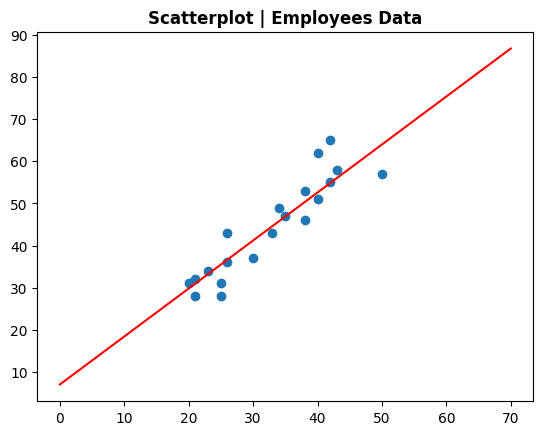

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.scatter(df1_5.Salary, df1_5.Age)
x = np.linspace(0, 70, 100)
plt.plot(x, 1.14*x + 7, color='red', label='y = 1.14x + 7')
plt.title('Scatterplot | Employees Data', fontdict={'fontweight': 'bold'})
print('Visualizing the absolute deviations fit:\n')

In [ ]:
# Table 1.1
## Data definition
data = {
    'Person': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
    'b': [4585, 7865, 3379, 6203, 2466, 3248, 4972, 3437, 3845, 3878, 5674],
    'a1': [2, 9, 7, 3, 1, 7, 6, 9, 1, 9, 5],
    'a2': [10, 10, 2, 6, 9, 5, 7, 4, 4, 2, 9]
}

## Create a pandas DataFrame
df1_1 = pd.DataFrame(data)

## Display the DataFrame
print("Coordinates Data:")
pprint(df1_1)

Coordinates Data:
    Person     b  a1  a2
0        1  4585   2  10
1        2  7865   9  10
2        3  3379   7   2
3        4  6203   3   6
4        5  2466   1   9
5        6  3248   7   5
6        7  4972   6   7
7        8  3437   9   4
8        9  3845   1   4
9       10  3878   9   2
10      11  5674   5   9


In [ ]:
## Run the 'sum of absolute deviations' model
model1_1 = minimize_sum_AD(df1_1, show_all=False, verbose=True)
c

Least Absolute Deviations Fit - Sum of Absolute Deviations: b = c[0]*a1 + c[1]*a2 + c[2]
Model: 25 variables, 33 constraints and 88 nonzeros
Optimal objective: 9.7e+03 units of deviation.

Optimized variables:
{'c[0]': '249.50', 'c[1]': '368.50', 'c[2]': '895.50'}

Variables' attributes: 
VarName                  |     x_j      low   &   up |     c_j      low   &   up   type
c[0]                     |  249.50     -inf      inf |    0.00    -0.40     1.20      C   
c[1]                     |  368.50     -inf      inf |    0.00    -0.67     2.67      C   
c[2]                     |  895.50     -inf      inf |    0.00    -0.16     0.04      C   
residuals[0]             | -494.50     -inf      inf |    0.00    -0.18     0.35      C   
residuals[1]             | 1039.00     -inf      inf |    0.00    -0.33     0.08      C   
residuals[2]             |    0.00     -inf      inf |    0.00    -0.20     0.80      C   
residuals[3]             | 2348.00     -inf      inf |    0.00    -0.11     

In [ ]:
## Run the 'maximum absolute deviation' model
model1_1 = minimize_sum_maxAD(df1_1, show_deviations=False, verbose=True)


Least Absolute Deviations Fit - Maximum Deviation: b = c[0]*a1 + c[1]*a2 + c[2]
Model: 14 variables, 22 constraints and 88 nonzeros
Optimal objective: 9.7e+03 units of deviation.

Optimized variables:
{'c[0]': '249.50', 'c[1]': '368.50', 'c[2]': '895.50'}

Variables' attributes: 
VarName                  |     x_j      low   &   up |     c_j      low   &   up   type
c[0]                     |  249.50     -inf      inf |    0.00    -0.40     1.20      C   
c[1]                     |  368.50     -inf      inf |    0.00    -0.67     2.67      C   
c[2]                     |  895.50     -inf      inf |    0.00    -0.16     0.04      C   
deviations[0]            |  494.50     0.00      inf |    1.00     0.65     1.18      C   
deviations[1]            | 1039.00     0.00      inf |    1.00     0.67     1.08      C   
deviations[2]            |    0.00     0.00      inf |    1.00     0.20      inf      C   
deviations[3]            | 2348.00     0.00      inf |    1.00     0.89     1.38     

## <font color=red>Optional</font>
### Some extra code to illustrate an exercise from Tutorial 1
Exercise 1.8.7. Play with the value for alfa and beta (direction of the constraint) to find the unique solution as indicated in the table provided by the authors.

In [ ]:
from gurobipy import *

alfa = -2
beta = -3

try:
    m = Model("Exercise 1.8.7 (2024)")
    m.Params.LogToConsole = 0
    m.Params.DualReductions = 0

    x = m.addVars(2, name = "x")              # Define decision variables
    x[1].lb = -1e21                           # -1e21 < -1e20 and therefore considered to be -inf

    m.setObjective( x.sum(), GRB.MINIMIZE)

    m.addConstr( alfa*x[0] + beta*x[1] >= 1, 'Constraint0')

    m.optimize()

    status = m.Status
    if status == GRB.UNBOUNDED:
        print("The model cannot be solved because it is unbounded")
    elif status == GRB.OPTIMAL:
        print(f"The optimal objective is {m.ObjVal:6.2f}")
    elif status != GRB.INF_OR_UNBD and status != GRB.INFEASIBLE:
        print(f"Optimization was stopped with status {status}")
    if status != GRB.OPTIMAL:
        print("Status code: ", status, "\nSee: https://www.gurobi.com/documentation/11.0/refman/optimization_status_codes.html#sec:StatusCodes")
    else:
        # Print for all variables the most relevant attributes
        print("\nVarName           |     x_j   low &  up   |     c_j  low & up ")
        for v in m.getVars():
            print(f"{v.VarName:17} |{v.X:8.3f} {v.lb:6.2f} {v.ub:6.2f} |{v.obj:8.2f} {v.saobjlow:6.2f} {v.saobjup:6.2f}")

        # Print for all constraints the most relevant attributes
        print("\nConstrName        |    RHS    low &  up   |   Slack     Pi   CBasis")
        for c in m.getConstrs():
            print(f"{c.ConstrName:17} |{c.rhs:8.2f} {c.SArhslow:6.2f} {c.SArhsup:6.2f} |{c.Slack:8.2f} {c.pi:6.2f} {c.cbasis:6}    {c.Sense}=")

except gp.GurobiError as e:
    print('Error code ' + str(e.errno) + ': ' + str(e))
except AttributeError:
    print('Encountered an attribute error')

Restricted license - for non-production use only - expires 2025-11-24
The model cannot be solved because it is unbounded
Status code:  5 
See: https://www.gurobi.com/documentation/11.0/refman/optimization_status_codes.html#sec:StatusCodes
